In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd
import plotly.plotly as py

In [8]:
data_frame = pd.read_csv("../dummy2.csv", header=None)

count_data = data_frame[1].as_matrix()

n_count_data = len(count_data)

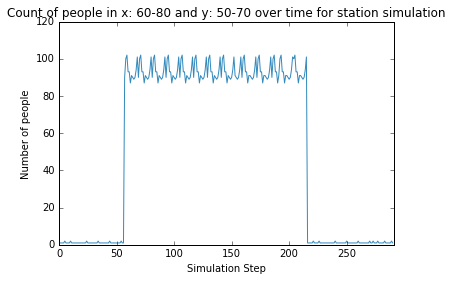

In [9]:
plt.plot(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Simulation Step")
plt.ylabel("Number of people")
plt.title("Count of people in x: 60-80 and y: 50-70 over time for station simulation")
plt.xlim(0, n_count_data)
plt.show()

In [10]:
# pymc
# set hyper-parameter as inverse of data mean
alpha = 1.0 / count_data.mean()
#alpha_1 = 1.0 / count_data[0:2400].mean()
#alpha_2 = 1.0 / count_data[2400:].mean()

# same prior for both lambdas
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)


# Set switchpoint prior as unifrom value for each day
#tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=1600)
#tau_2 = pm.DiscreteUniform("tau_2", lower=1600, upper=n_count_data)

# Or uniform throughout
tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data)
tau_2 = pm.DiscreteUniform("tau_2", lower=0, upper=n_count_data)


@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2, lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):
    out = np.zeros(n_count_data)
    out[:tau_1] = lambda_1  # lambda before tau is lambda1
    out[tau_1:tau_2] = lambda_2  # lambda after (and including) tau is lambda2
    out[tau_2:] = lambda_3
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, lambda_3, tau_1, tau_2])

# Markov Model Monte Carlo
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

lambda_1_samples = mcmc.trace("lambda_1")[:]
lambda_2_samples = mcmc.trace("lambda_2")[:]
lambda_3_samples = mcmc.trace("lambda_3")[:]
tau_1_samples = mcmc.trace("tau_1")[:]
tau_2_samples = mcmc.trace("tau_2")[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 65.3 sec

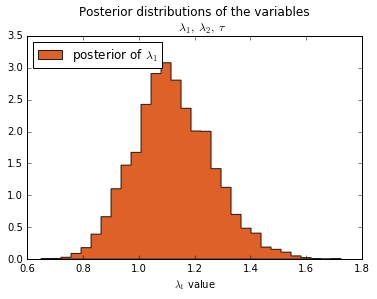

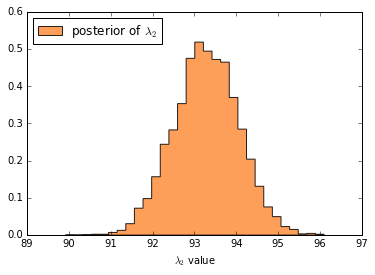

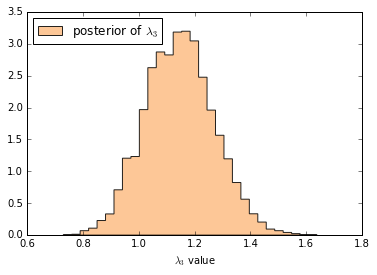

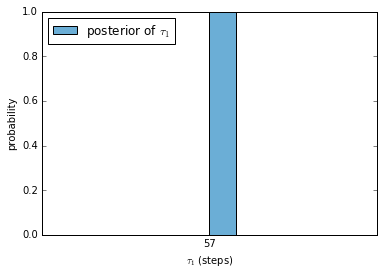

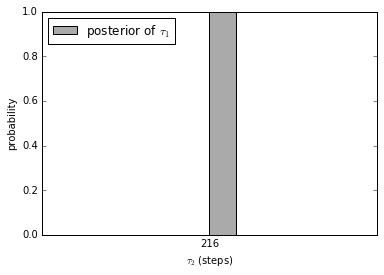

In [35]:
# Histogram of samples

# LAMBDA 1
plt.hist(lambda_1_samples, histtype="stepfilled", bins=30, alpha=0.85,
    label = "posterior of $\lambda_1$", color="#D94701", normed=True)
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.legend(loc="upper left")
#plt.xlim([0, n_count_data])
plt.xlabel("$\lambda_1$ value")
plt.show()

#LAMBDA 2
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#FD8D3C", normed=True)
plt.legend(loc="upper left")
#plt.xlim([0, n_count_data])
plt.xlabel("$\lambda_2$ value")
plt.show()

#lAMBDA 3
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color="#FDBE85", normed=True)
plt.legend(loc="upper left")
#plt.xlim([0, n_count_data])
plt.xlabel("$\lambda_3$ value")
plt.show()


def hist_calcs(samples):
    #samples = tau_2_samples
    vals = sorted(list(set(samples)))

    counts = np.zeros(len(vals))
    for num in samples:
        counts[vals.index(num)] += 1
        
    percent = counts / float(samples.shape[0])
    
    return(vals, percent)

# TAU 1
vals, percentages = hist_calcs(tau_1_samples)
plt.bar(vals, percentages, label=r"posterior of $\tau_1$", color="#6BAED6")
plt.xticks(vals[::2])
plt.legend(loc="upper left")
plt.xlabel(r"$\tau_1$ (steps)")
plt.ylabel("probability");
mode = hist_calcs(tau_1_samples)[0][0]
plt.xlim(mode - 5, mode + 5)
plt.show()

#TAU 2
vals, percentages = hist_calcs(tau_2_samples)
plt.bar(vals, percentages, label=r"posterior of $\tau_1$", color="#AAAAAA")
plt.xticks(vals[::2])
plt.legend(loc="upper left")
plt.xlabel(r"$\tau_$ (steps)")
plt.ylabel("probability");
mode = hist_calcs(tau_2_samples)[0][0]
plt.xlim(mode - 5, mode + 5)
plt.show()




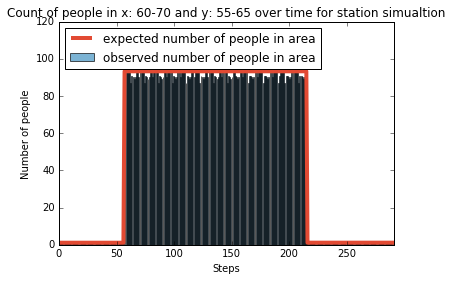

In [12]:
# Sampling from posterior distribution
N = tau_1_samples.shape[0]

expected_area_density = np.zeros(n_count_data)

for step in range(0, n_count_data):
    l1 = step < tau_1_samples
    l2 = np.logical_and(step >= tau_1_samples, step < tau_2_samples)
    l3 = step >= tau_2_samples
    expected_area_density[step] = (lambda_1_samples[l1].sum() +
                                    lambda_2_samples[l2].sum() + lambda_3_samples[l3].sum())/ N

    
plt.plot(range(n_count_data), expected_area_density, lw=4, color="#E24A33",
         label="expected number of people in area")
plt.xlim(0, n_count_data)
plt.xlabel("Steps")
plt.ylabel("Number of people")
plt.title("Count of people in x: 60-70 and y: 55-65 over time for station simualtion")
#plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed number of people in area")

plt.legend(loc="upper left");

plt.show()


In [37]:
import scipy.stats as st
print(st.mode(tau_1_samples))
print(st.mode(tau_2_samples))
print(st.mode(lambda_1_samples))
print(st.mode(lambda_2_samples))
print(st.mode(lambda_3_samples))

ModeResult(mode=array([57]), count=array([30000]))
ModeResult(mode=array([216]), count=array([30000]))
ModeResult(mode=array([1.11912308]), count=array([53]))
ModeResult(mode=array([93.8242481]), count=array([45]))
ModeResult(mode=array([1.0370305]), count=array([38]))
